# Mixtures
The goal of this notebook is to examine mixtures of outputs from nucleosynthetic processes.

Begin by installing and importing the necessary python libraries

In [1]:
import sys, io, requests
from ipywidgets import *

!{sys.executable} -m pip install --quiet wnutils
!{sys.executable} -m pip install --quiet matplotlib

import matplotlib.pyplot as plt
import wnutils.xml as wx 
import numpy as np
from scipy.optimize import curve_fit

Define a routine to retrieve zone abundances from the xml data.

In [2]:
def get_zone_abunds(my_xml):
    zones = my_xml.get_zone_data()
    proc = {}
    for key in zones:
        proc[key] = {}
        for tup in zones[key]['mass fractions']:
            proc[key][tup[0]] = zones[key]['mass fractions'][tup] / tup[2]
    return proc

Read in the nucleosynthesis processes data and store in a wnutils XML object.  The default is to use files downloaded from [OSF](https://osf.io/5shf2/).  To use your own data, put them in your working directory or uploading to Colab or Binder.  Then uncomment the second line and replace *example.xml* with the chosen name.

In [3]:
rsp = wx.Xml(io.BytesIO(requests.get('https://osf.io/5ztd7/download').content))
#wx.Xml('example.xml')

Retrieve the data for the processes.

In [4]:
result = get_zone_abunds(rsp)

Define a routine to retrieve the data for the processes and store in arrays.

In [5]:
def get_proc(sp, norm_species):

    y = []

    proc = {}
    for key in result:
        proc[key] = np.zeros(len(sp))
        count = 0
        for s in sp:
            if s in result[key]:
                proc[key][count] = result[key][s]
            count += 1
            
    for key in result:
        proc[key] /= np.sum(proc[key])
        
    return proc

Specify the species of interest.  Specify the normalizing species and the labelling string.

In [6]:
sp = ('mo92', 'mo94', 'mo95', 'mo96', 'mo97', 'mo100')
a = np.array([92, 94, 95, 96, 97, 100])
norm_species = 'mo96'
sp_string = '^iMo/^{96}Mo'

Get the process data for the species.  Set the normalization index.

In [7]:
proc = get_proc(sp, norm_species)
i_norm = sp.index(norm_species)

proc['ws'][1] = 0.1 * proc['p'][1]

Plot the process contributions.

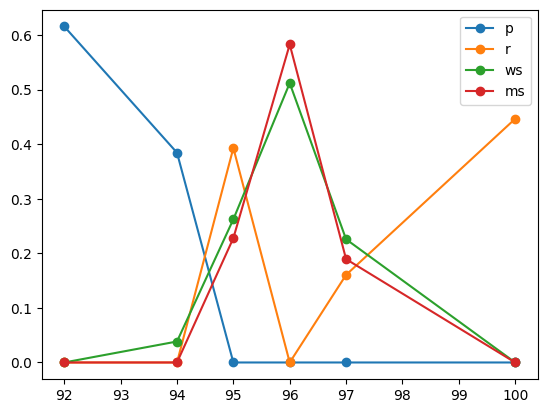

In [8]:
for key in proc:
    plt.plot(a, proc[key], 'o-', label = key)
    
plt.legend()

Input the standard abundance ratios.  Enter the normalizing species as 1.

In [9]:
standard = np.array([0.883359, 0.552511, 0.953254, 1, 0.573933, 0.581468])

In [10]:
def fit_function(x, a_p, a_r, a_ms, a_ws):
    result = a_p * proc['p'] + a_r * proc['r'] + a_ms * proc['ms'] + a_ws * proc['ws']
    result /= result[i_norm]
    return result

Compute the best fit to the standard.

In [11]:
popt_std, pcov_std = curve_fit(fit_function, a, standard, bounds=(0, [1, 1, 1, 1]))

Plot the fit.

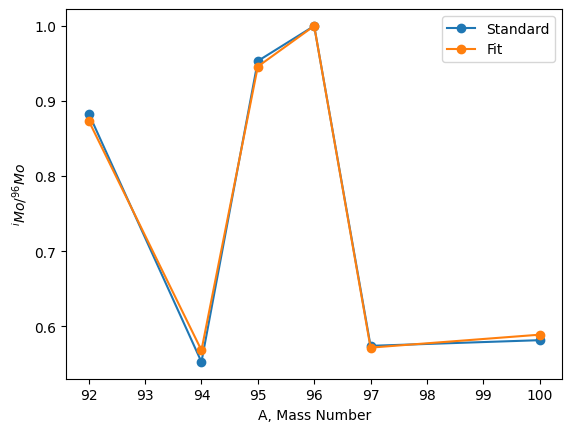

In [12]:
plt.plot(a, standard, '-o', label='Standard')

plt.plot(a, fit_function(a, *popt_std), '-o', label='Fit')

plt.xlabel('A, Mass Number')
plt.ylabel('$' + sp_string + '$')
plt.legend()

In [13]:
sample = np.array([-54.1, -26.1, -3.4, 0., 11.3, -40.9])
sigma = np.array([34.0, 10.1, 3.9, 0.1, 2.5, 9.5])

In [14]:
rng = 1000
step = 10
include_data = True

@widgets.interact
def f(p_proc=(-rng,rng,step), r_proc=(-rng,rng,step), ms_proc=(-rng,rng,step), ws_proc=(-rng,rng,step)):
    c_p = (1 + p_proc/1.e6) * popt_std[0]
    c_r = (1 + r_proc/1.e6) * popt_std[1]
    c_ms = (1 + ms_proc/1.e6) * popt_std[2]
    c_ws = (1 + ws_proc/1.e6) * popt_std[3]

    standard = fit_function(a, *popt_std)
    standard /= standard[i_norm]
    result = c_p * proc['p'] + c_r * proc['r'] + c_ms * proc['ms'] + c_ws * proc['ws']
    result /= result[i_norm]
    mu = 1.e6 * (result / standard - 1)
    
    plt.plot(a, mu, '-o', label='fit')
    if include_data:
        plt.errorbar(a, sample, fmt='-o', yerr=sigma, label='data')

    plt.xlabel('A, Mass Number')
    plt.ylabel('$\\mu(' + sp_string + ')$')
    if include_data:
        plt.legend()

interactive(children=(IntSlider(value=0, description='p_proc', max=1000, min=-1000, step=10), IntSlider(value=…